In [4]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import acoular as ac
import matplotlib.animation as anim


In [5]:

dataName = '2025-01-28_15-18-43_492418'

resFolderName = 'out/beamforming_results_25_02_16/'+dataName

cameraPosition = 1
dotsize = 5.5
currentFrequencyBand = 0

cameraAngles = np.array([[-133.33136452241695,-27.020027669675454],[164.2465834869733,64.11592446841624]]) # dim[0] = cam1/2; dim[1] = azimuth/elevation

# Camera 1 Azimuth: -133.33136452241695
# Camera 1 Altitude: -27.020027669675454
# Camera 2 Azimuth: 164.2465834869733
# Camera 2 Altitude: 64.11592446841624

# Open and read the JSON file
with open(resFolderName + '/evaluation_config.json', 'r') as file:
    config_data = json.load(file)

# Access the output folder path
out_folder = config_data['out_folder']
print(f"Output Folder: {out_folder}")

# read Data
result = np.load(resFolderName+ '/result_'+dataName + ".npy")
map = result
resolution = config_data['calc_grid_res_meters']
frequencyBands = config_data['frequency_bands']
frameRate = config_data['frame_rate_fps']

Output Folder: ./evaluation/out/


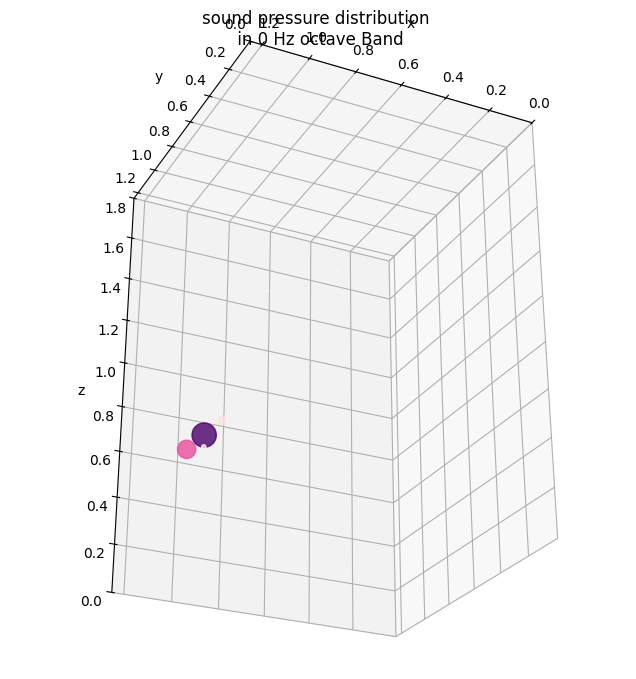

In [ ]:
fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')

# ax.view_init(elev=10, 
#              azim=270, 
#              roll=0)
ax.view_init(elev=cameraAngles[0,cameraPosition], 
             azim=cameraAngles[1,cameraPosition], 
             roll=0)
ax.set_proj_type('persp', focal_length=0.547)

x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[2]*resolution,map.shape[2]),
                            np.linspace(0,map.shape[3]*resolution,map.shape[3]), 
                            np.linspace(0,map.shape[4]*resolution,map.shape[4]))



scat = ax.scatter(x_m, y_m, z_m, c = map[1,1], s = map[1,1]*10**dotsize, alpha = 0.8, cmap = 'RdPu')
# -map[1,1]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0, map.shape[2]*resolution)
ax.set_ylim(map.shape[3]*resolution, 0)
ax.set_zlim(0,map.shape[4]*resolution)
ax.set_title('sound pressure distribution \n in '+str(currentFrequencyBand)+' Hz octave Band')
ax.set_aspect('equal')


def update(frame):
    # color = np.nan_to_num(map[currentFrequencyBand,frame,:,:,:])
    size = map[currentFrequencyBand,frame,:,:,:].flatten()*10**dotsize
    # alpha = map[currentFrequencyBand,frame,:,:,:]*0.2
    # scat.set_alpha(alpha)
    # scat.set_color(color)
    scat.set_sizes(size)
    scat.set_cmap = 'RdPu'
    # Reshape the color array to (N,) where N is the number of points
    color = map[currentFrequencyBand, frame, :, :, :].flatten()

    # Normalize color values to be between 0 and 1
    color = (color - np.min(color)) / (np.max(color) - np.min(color) + 1e-6)

    # Add an alpha channel (0.8 transparency)
    alpha = np.full(color.shape, 0.8)
    color_rgba = np.stack([color, color, color, alpha], axis=-1)

    scat.set_color(color_rgba)

    return scat,


ani = anim.FuncAnimation(fig=fig, func=update, frames=map.shape[1], interval=(1/25)*1000)
plt.show()

resFileName = 'out/video_data/'+dataName+'camera_'+str(cameraPosition)+'.mp4'
ani.save(filename=resFileName, writer="ffmpeg")

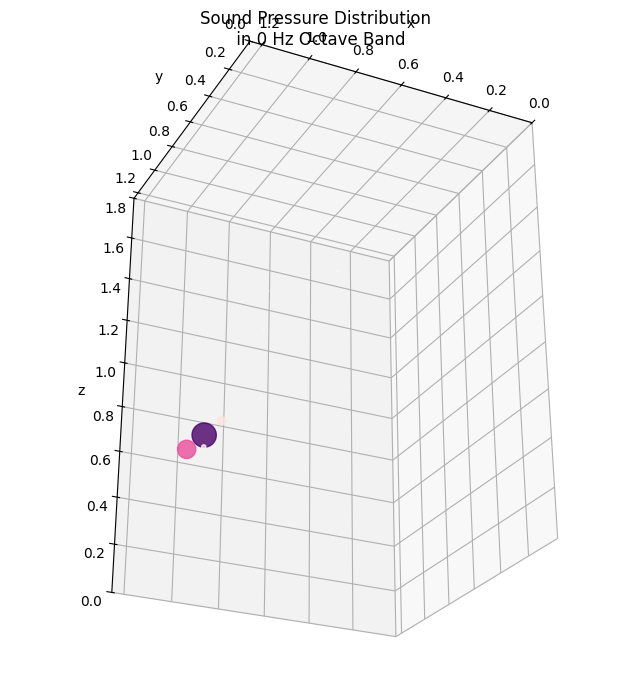

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

In [ ]:
# Create a figure for the 3D plot
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(projection='3d')

# Set the camera angle for the 3D plot using predefined angles from cameraAngles array
# Elevation and azimuth are set based on the current camera position
ax.view_init(elev=cameraAngles[0, cameraPosition], 
             azim=cameraAngles[1, cameraPosition], 
             roll=0)

# Set the projection type to perspective with a specific focal length
ax.set_proj_type('persp', focal_length=0.547)

# Create a 3D grid for the scatter plot using the dimensions of the 'map' array
x_m, y_m, z_m = np.meshgrid(np.linspace(0, map.shape[2] * resolution, map.shape[2]),
                            np.linspace(0, map.shape[3] * resolution, map.shape[3]), 
                            np.linspace(0, map.shape[4] * resolution, map.shape[4]))

# Initialize a 3D scatter plot with color and size based on the 'map' array data
scat = ax.scatter(x_m, y_m, z_m, 
                  c=map[1, 1],  # Initial color
                  s=map[1, 1] * 10**dotsize,  # Initial size
                  alpha=0.8,    # Transparency
                  cmap='RdPu')  # Color map

# Label the axes and set limits
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0, map.shape[2] * resolution)
ax.set_ylim(map.shape[3] * resolution, 0)
ax.set_zlim(0, map.shape[4] * resolution)

# Add a title to the plot showing the current frequency band
ax.set_title('Sound Pressure Distribution \n in ' + str(currentFrequencyBand) + ' Hz Octave Band')

# Set the aspect ratio of the 3D plot to be equal
ax.set_aspect('equal')

# Update function to animate each frame of the scatter plot
def update(frame):
    # Get the color and size data for the current frame
    color = np.nanmap[currentFrequencyBand, frame, :, :, :]
    size = map[currentFrequencyBand, frame, :, :, :] * 10**dotsize

    # Optionally set transparency based on sound pressure values
    # alpha = map[currentFrequencyBand, frame, :, :, :] * 0.2
    # scat.set_alpha(alpha)

    # Update color and size of the scatter plot for the current frame
    scat.set_color(color)
    scat.set_sizes(size)
    return scat,

# Create the animation with the update function
# 'frames' sets the total number of frames, and 'interval' sets the delay between frames
ani = anim.FuncAnimation(fig=fig, 
                         func=update, 
                         frames=map.shape[1], 
                         interval=(1/25) * 1000)  # 25 FPS

# Display the plot (useful for debugging)
plt.show()

# Save the animation as an MP4 video file using FFmpeg
resFileName = 'out/video_data/' + dataName + 'camera_' + str(cameraPosition) + '.mp4'
ani.save(filename=resFileName, writer="ffmpeg")
